# 基于机器学习的心脏病预测模型构建与效能评估

## 一、任务分析与数据导入
### 1.1 项目背景与目标

心脏病是全球主要的死亡原因之一，世界卫生组织（WHO）提供的数据显示，全球近31%的人口死于心脏相关疾病，每年约有1520万人因此失去生命。这不仅给个人家庭带来了巨大的身心压力，也使社会医疗系统承受了沉重的经济负担。随着生活方式的改变和老龄化社会的到来，心脏病的发病率逐年上升，早期预防心脏病显得尤为重要。通过常规的临床数据分析，检测心脏病发作等心血管疾病是一项艰巨的挑战，而机器学习技术可以在医疗行业中为决策和准确预测提供了有效的解决方案。

本项目的主要目标包括：
1. 构建一个高效的心脏病预测模型，以实现对心脏病风险的早期预警，帮助医生和患者及时采取预防措施。
2. 识别影响心脏病发生的关键因素，通过数据分析揭示潜在的风险因素，为后续的研究提供基础。
3. 为医疗决策提供数据支持，利用模型的预测能力，辅助医生在临床实践中做出更为科学的决策。
4. 探索机器学习在医疗健康领域的应用，推动数据驱动的医疗创新，提高医疗服务的质量和效率。

通过以上目标的实现，我们希望能够为心脏病疾病的预防和治疗提供有力的支持，改善患者的生活质量，降低社会医疗负担。

### 1.2 数据集介绍

本项目使用的数据集来自于Kaggle，该数据集包含以下特征:
- **Age**: 年龄（年）
- **Sex**: 性别（M=男性；F=女性）
- **ChestPain**: 胸痛类型
  - TA: 典型心绞痛
  - ATA: 非典型心绞痛
  - NAP: 非心绞痛性疼痛
  - ASY: 无症状
- **RestingBP**: 静息血压（mmHg）
- **Cholesterol**: 血清胆固醇（mg/dl）
- **FastingBS**: 空腹血糖（如果空腹血糖 > 120 毫克/分升则为1；否则0）
- **RestingECG**: 静息心电图结果
  - Normal: 正常
  - ST: ST-T波异常（T波倒置和/或ST段抬高或降低 > 0.05 毫伏）
  - LVH：根据Estes标准显示可能或肯定的左心室肥大]
- **MaxHR**: 最大心率（每分钟跳动次数）
- **ExerciseAngina**: 运动诱发心绞痛（Y=是；N=否）
- **Oldpeak**: 旧峰值=ST段（数值测量在压低）
- **ST_Slope**: 心电图ST段的斜率
  - Up: 上升
  - Flat: 平坦
  - Down：下降
- **HeartDisease**: 是否患有心脏病（0=否；1=是）

### 1.3 数据导入

In [10]:
# 导入必要的库
# %pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix,classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  #忽略警告

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取数据集
df = pd.read_csv('heart.csv')

## 二、数据探索及预处理

### 2.1 数据集探索与统计分析

In [11]:
# 查看数据集基本信息
print("数据集形状:", df.shape)
print("\n数据集前5行:")
print(df.head())
print("\n数据集基本信息:")
print(df.info())
print("\n数据集统计描述:")
print(df.describe())

# 查看每个特征的唯一值数量
print("\n每个特征的唯一值数量:")
print(df.nunique())

数据集形状: (1303, 12)

数据集前5行:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------       

通过对数据集的初步探索，我们发现：

1. **数据规模**：
   - 样本数量：1303条记录
   - 特征数量：12个特征（11个预测特征 + 1个目标变量）

2. **特征类型**：
   - 数值型特征：Age, RestingBP, Cholesterol, MaxHR, Oldpeak
   - 类别型特征：Sex, ChestPainType, FastingBS, RestingECG, ExerciseAngina, ST_Slope
   - 目标特征：HeartDisease（二分类：0=无，1=有）

3. **数据分布**：
   - 年龄范围：28-77岁
   - 静息血压范围：0-200 mmHg
   - 胆固醇水平：0-603 mg/dl
   - 最大心率：60-202 次/分

### 2.2 数据清洗

#### 2.2.1 缺失值检查

In [12]:
# 检查缺失值
print("缺失值统计:")
print(df.isnull().sum())

缺失值统计:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


#### 2.2.2 异常值识别标准
之前的数据探索得知的**数据分布情况**：
   - 年龄范围：28-77岁
   - 静息血压范围：0-200 mmHg
   - 胆固醇水平：0-603 mg/dl
   - 最大心率：60-202 次/分

医学人体理论极限所能达到的指标：
|指标|极限数值范围|
| ---- | ---- |
|Age（年龄）|0-150岁|
|RestingBP（静息血压）|≥90mmHg（下限），可达370mmHg左右（上限极罕见情况）|
|Cholesterol（胆固醇）|≥100mg/dl（下限），暂无明确上限数值|
|MaxHR（最大心率）|≥60bpm（下限），可短暂超过220 - 年龄（上限难确定确切值）|

根据医学人体所能达到的指标，我们仅需处理不符合生理范围的数据如Cholesterol即可

#### 2.2.3 异常值处理

先查看一下异常值

In [13]:
print("处理前的异常值情况：")

# 检查胆固醇低于100的情况
chol_abnormal = df[df['Cholesterol'] < 100]
print(f"胆固醇低于100的记录数: {len(chol_abnormal)}")
if len(chol_abnormal) > 0:
    print("异常值:", chol_abnormal['Cholesterol'].values)

处理前的异常值情况：
胆固醇低于100的记录数: 304
异常值: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


可以发现胆固醇异常值都为0，很大概率是根本没有测量，下面是具体的处理方法：

**胆固醇异常值处理**：
   - 使用正常范围内（≥100 mg/dl）样本的平均值进行填充
   - 这种方法保持了数据的整体分布特征

In [14]:
# 处理异常值
df_cleaned = df.copy()

# 处理胆固醇异常值（使用正常值的平均值填充）
normal_chol = df[df['Cholesterol'] >= 100]['Cholesterol'].mean()
df_cleaned.loc[df_cleaned['Cholesterol'] < 100, 'Cholesterol'] = normal_chol

# 打印处理后的范围
print("\n处理后的取值范围：")
for feature in ['Cholesterol']:
    print(f"{feature}:")
    print(f"最小值: {df_cleaned[feature].min():.3f}")
    print(f"最大值: {df_cleaned[feature].max():.3f}")
    print(f"平均值: {df_cleaned[feature].mean():.3f}")

# 更新数据集
df = df_cleaned.copy()


处理后的取值范围：
Cholesterol:
最小值: 100.000
最大值: 603.000
平均值: 245.306


### 2.3 数据预处理步骤

1. **类别型特征处理**：
   - **性别(Sex)**：
     * 原始值：M/F
     * 转换为：1/0
   - **胸痛类型(ChestPainType)**：
     * 原始值：AT/ATA/NAP/ASY
     * 处理：独热编码
   - **心电图结果(RestingECG)**：
     * 原始值：Normal/ST/LVH
     * 处理：独热编码
   - **运动心绞痛(ExerciseAngina)**：
     * 原始值：Y/N
     * 转换为：1/0
   - **ST斜率(ST_Slope)**：
     * 原始值：Up/Flat/Down
     * 处理：独热编码

2. **数值型特征处理**：

   - **已编码特征**：
     * 空腹血糖(FastingBS)：保持0/1编码

模型训练前的数据预处理实施步骤将在特征工程中进行

## 三、数据可视化分析

### 3.1 特征分布情况分析

#### 3.1.1 数值型特征分布
首先需要了解每个特征的基本分布情况，这有助于：
- 验证数据预处理的效果
- 发现可能的异常模式
- 确定后续分析的方向

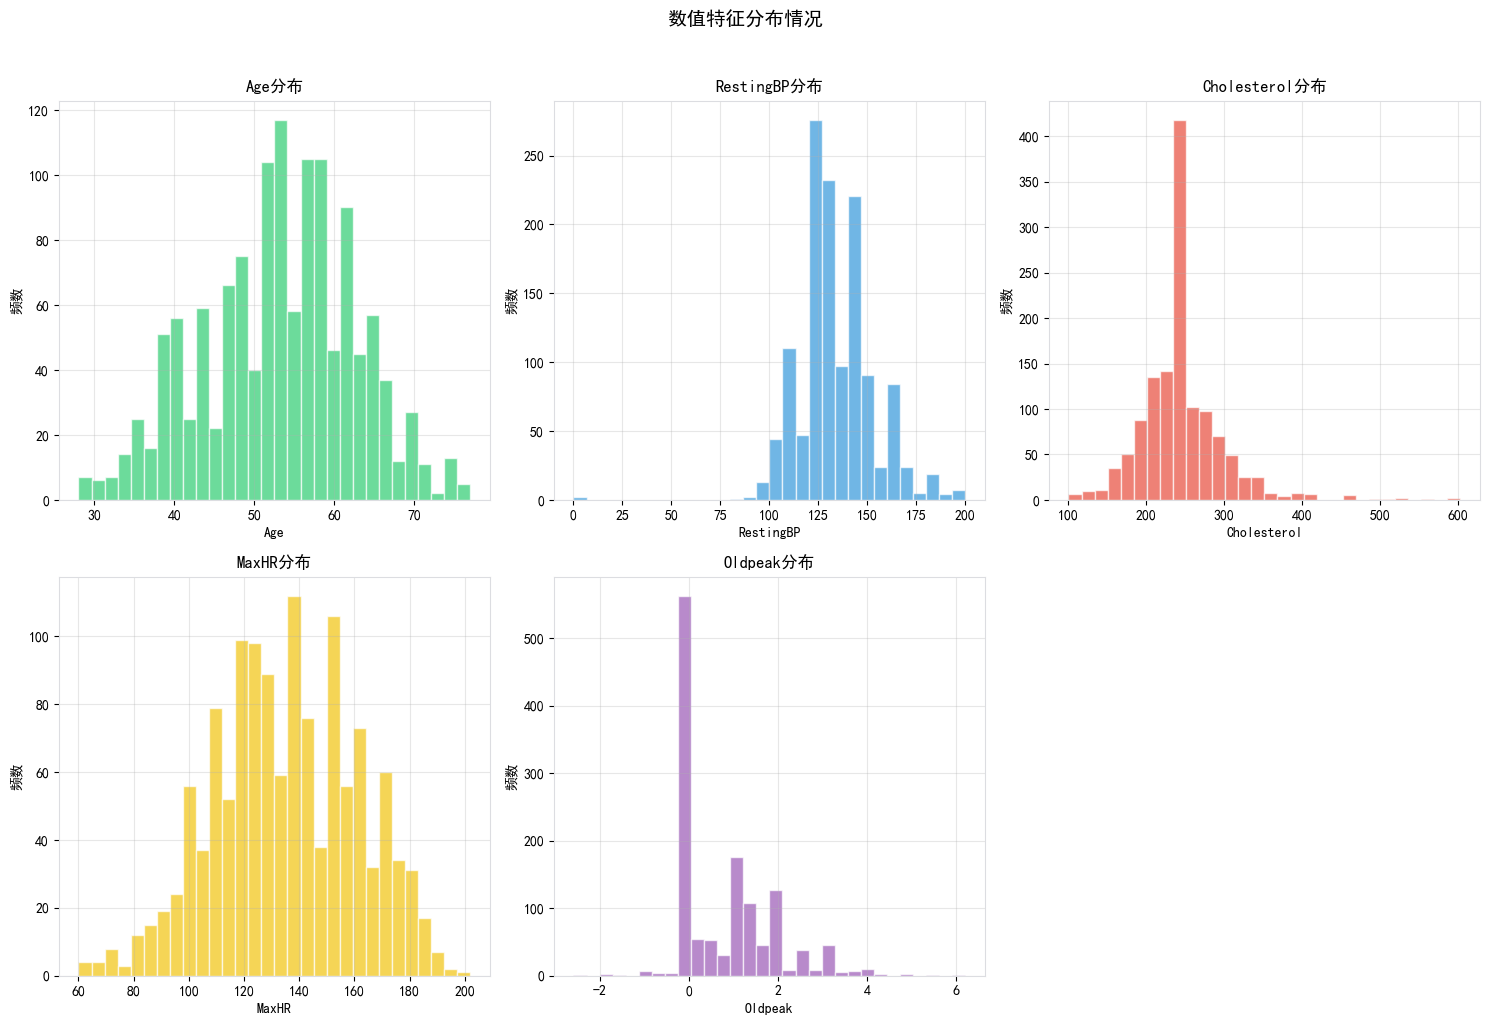

In [15]:
# 绘制数值型特征的分布直方图
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6']

# 使用enumerate和zip同时遍历特征列表和颜色列表
# enumerate提供索引idx和元组(feature, color)
# zip将numeric_features和colors打包成元组对
# idx用于选择子图位置
# feature是特征名称
# color是对应的颜色值
for idx, (feature, color) in enumerate(zip(numeric_features, colors)):
    # 计算直方图数据
    axes[idx].hist(df[feature], bins=30, edgecolor='white', 
                  color=color, alpha=0.7)
    
    # 美化标题和标签
    axes[idx].set_title(f'{feature}分布', fontsize=12) 
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('频数', fontsize=10)
    
    # 设置网格
    axes[idx].grid(True, alpha=0.3)
    
    # 美化边框
    for spine in axes[idx].spines.values():
        spine.set_edgecolor('#dcdde1')

# 移除多余的子图
if len(numeric_features) < len(axes):
    axes[-1].remove()

# 调整布局
plt.suptitle('数值特征分布情况', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


**分析发现**：

- `Age`呈现近似正态分布，集中在40-65岁之间，这符合心脏病的好发年龄段

- `RestingBP`呈现右偏分布，大多数值在120-140mmHg之间，符合正常人群血压分布

- `Cholesterol`在处理异常值后分布更加合理，主要集中在150-350mg/dl之间

- `MaxHR`呈现近似正态分布，集中在120-160次/分钟，符合生理范围

- `Oldpeak`在处理负值后呈现右偏分布，大多数值接近0，这更符合医学实际


#### 3.1.2 类别型特征分布

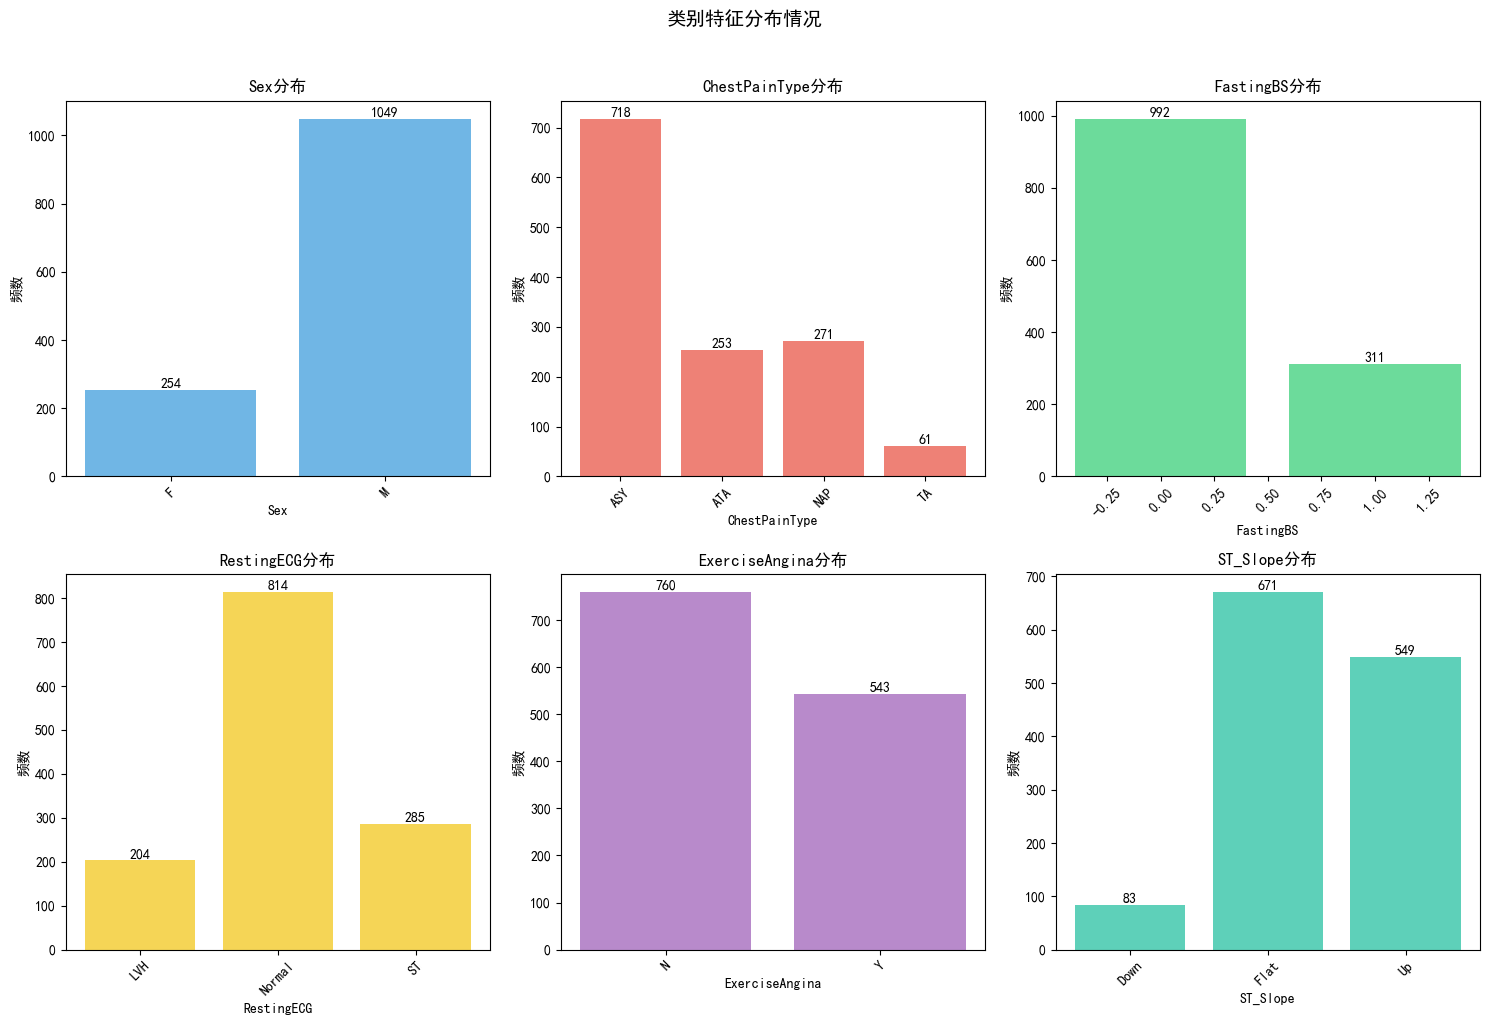

In [16]:
# 创建类别型特征的分布图
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6', '#1abc9c']

for idx, (feature, color) in enumerate(zip(categorical_features, colors)):
    # 计算每个类别的数量并排序
    value_counts = df[feature].value_counts().sort_index()
    
    # 创建条形图
    axes[idx].bar(value_counts.index, value_counts.values, color=color, alpha=0.7)
    
    # 在每个条形上添加数值标签
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')
    
    # 设置标题和标签
    axes[idx].set_title(f'{feature}分布', fontsize=12)
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('频数', fontsize=10)
    
    # 调整刻度标签角度
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

plt.suptitle('类别特征分布情况', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**分析发现**：

1. 性别分布显示男性样本(M)是女性(F)的接近4倍，存在明显的性别不平衡
2. 胸痛类型中无症状(ASY)最为常见，而典型心绞痛(TA)相对较少
3. ST段斜率正常、平坦类型占比最高


### 3.2 目标特征相关性分析

基于清洗后的数据，我们需要了解目标特征与其他特征的相互关系：

- 识别强相关特征组合
- 确定与目标变量最相关的特征

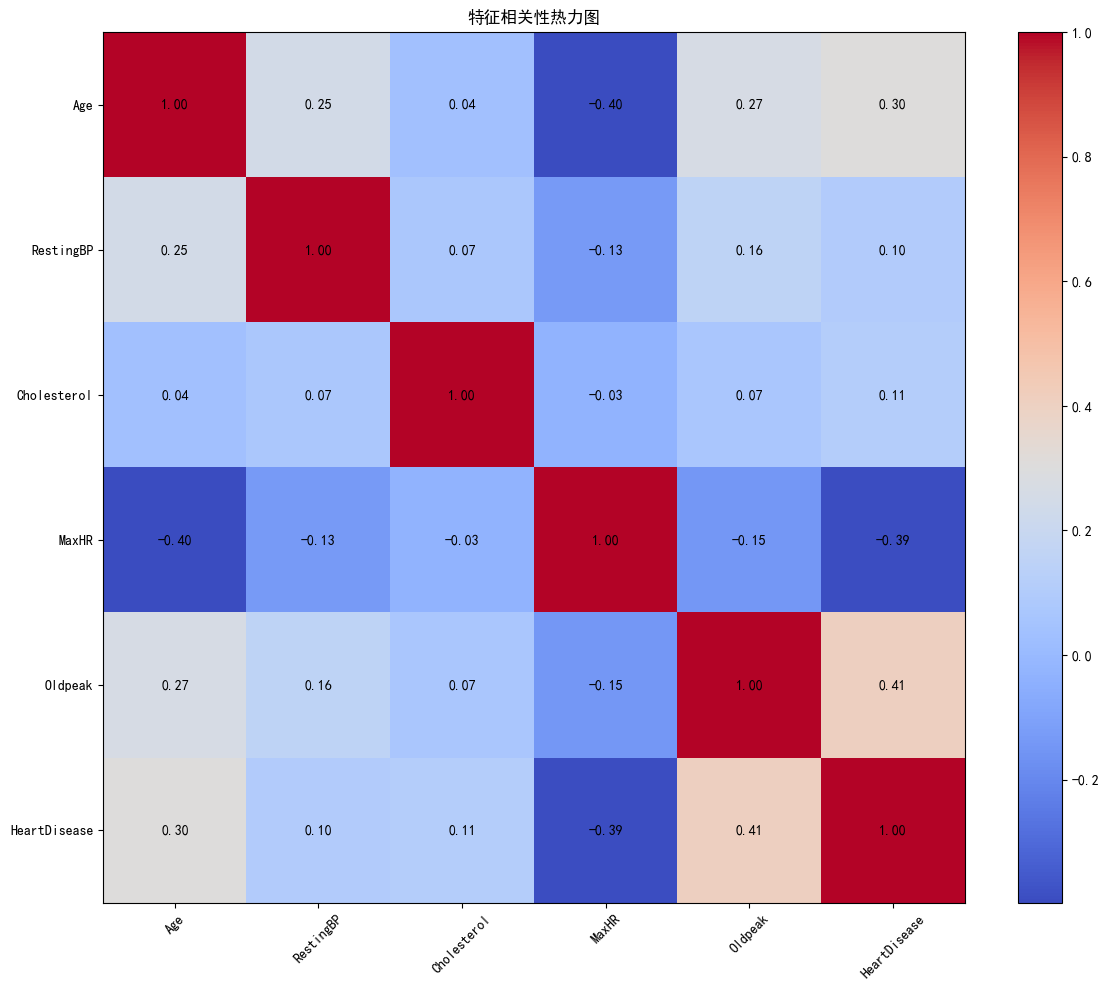


重要特征相关性：

与心脏病的相关性：
HeartDisease    1.000000
Oldpeak         0.405218
Age             0.301882
Cholesterol     0.110366
RestingBP       0.103214
MaxHR          -0.392009
Name: HeartDisease, dtype: float64


In [17]:
# 计算相关性矩阵，排除二分类变量FastingBS与类别特征
numeric_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'FastingBS']
correlation_matrix = df[numeric_columns].corr()

# 绘制相关性热力图
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()

# 添加相关系数标签
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                ha='center', va='center')

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('特征相关性热力图')
plt.tight_layout()
plt.show()

# 输出相关性
print("\n重要特征相关性：")
# 获取与目标变量(HeartDisease)的相关性
target_correlations = correlation_matrix['HeartDisease'].sort_values(ascending=False)
print("\n与心脏病的相关性：")
print(target_correlations)

相关性分析结论

- 强相关特征
    * `Oldpeak`(+0.41): ST段压越大，患病风险越高
    * `MaxHR`(-0.39): 最大心率越低，患病风险越高

- 中等相关特征
    * `Age`(+0.3): 年龄越大，患病风险略增
    
- 弱相关特征
    * `Cholesterol`(+0.11): 与胆固醇呈弱负相关
    * `RestingBP`(+0.1): 与静息血压负相关

**结论**: 特征工程建模时可以重点关注`Oldpeak`和`MaxHR`这两个特征。

### 3.3 其他相关性分析

除了目标特征的数值型相关性分析，我们也可以了解其他特征间的相互关系和目标特征的数值型相关性分析，以便更好地理解数据。

#### 3.3.1 心率与年龄的散点图分布
众所周知，心率与年龄有着密切的关系，下面我们来分析一下心率与年龄的散点图分布：

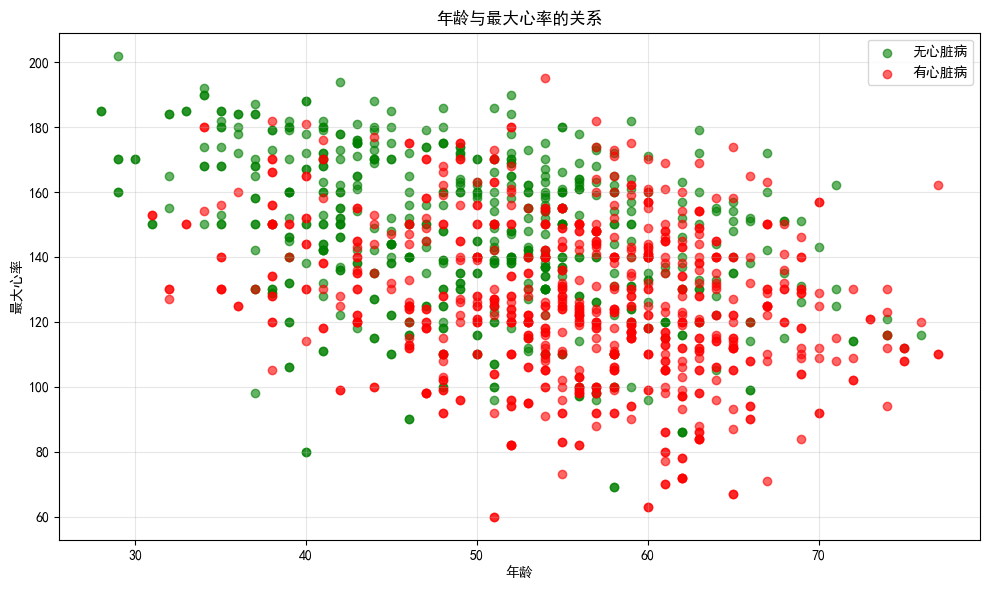

In [18]:
plt.figure(figsize=(10, 6))
colors = ['green', 'red']
for i, status in enumerate(['无心脏病', '有心脏病']):
    mask = df['HeartDisease'] == i
    plt.scatter(df[mask]['Age'], df[mask]['MaxHR'], 
                c=colors[i], label=status, alpha=0.6)
plt.title('年龄与最大心率的关系', fontsize=12)
plt.xlabel('年龄', fontsize=10)
plt.ylabel('最大心率', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**分析发现**：

1.随着年龄增长，最大心率呈现明显的下降趋势

2.心脏病患者（红点）的最大心率普遍低于同龄健康人群（绿点），尤其在50岁以上人群中这种差异更为明显

#### 3.3.2 不同胸痛类型的心脏病比例堆叠图

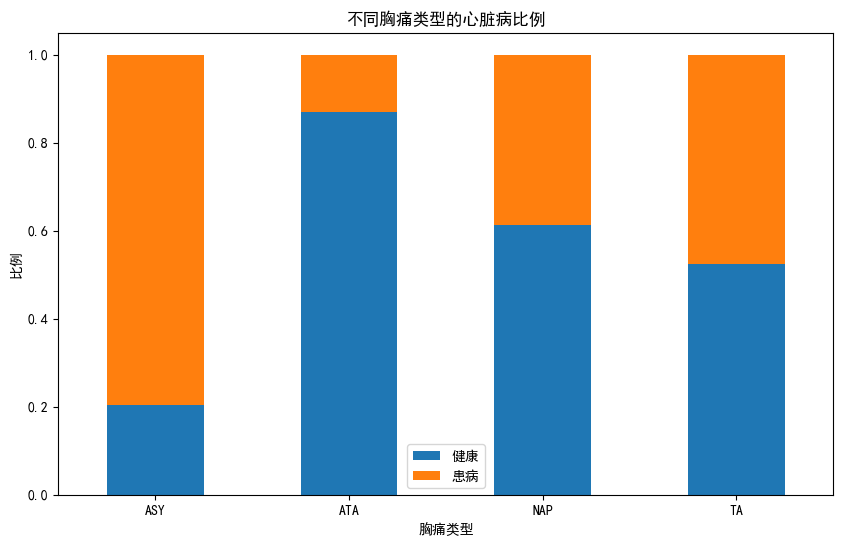

In [19]:
# 计算不同胸痛类型中心脏病的比例
pain_disease = pd.crosstab(df['ChestPainType'], df['HeartDisease'], normalize='index')
pain_disease.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('不同胸痛类型的心脏病比例')
plt.xlabel('胸痛类型')
plt.ylabel('比例')
plt.legend(['健康', '患病'])
plt.xticks(rotation=0)
plt.show()


**分析发现**：

1. **非典型心绞痛(ATA)患者中约90%是健康的**，显示非典型心绞痛可能不是心脏病的主要指征。

2. **无症状(ASY)和非典型心绞痛(NAP)的患者中**，有心脏病的比例明显更高，这提示**不典型症状反而需要更多关注**。

## 四、特征工程

### 4.1 特征选择与构建

基于前面的相关性分析结果（`Oldpeak`: +0.41, `MaxHR`: -0.39, `Age`: +0.3），我们将重点关注这些强相关特征，并尝试构建新的交互特征：

In [20]:
# 1. 分离数值特征和类别特征
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# 2. 构建交互特征
df_features = df.copy()
df_features['Oldpeak_Age'] = df['Oldpeak'] * df['Age']
df_features['MaxHR_Age'] = df['MaxHR'] * df['Age']
df_features['Oldpeak_MaxHR'] = df['Oldpeak'] * df['MaxHR']

# 3. 显示新特征的相关性
new_correlations = df_features[['Oldpeak_Age', 'MaxHR_Age', 'Oldpeak_MaxHR', 'HeartDisease']].corr()['HeartDisease']
print("新构建特征与心脏病的相关性：")
print(new_correlations)

新构建特征与心脏病的相关性：
Oldpeak_Age      0.404010
MaxHR_Age       -0.083980
Oldpeak_MaxHR    0.364401
HeartDisease     1.000000
Name: HeartDisease, dtype: float64


- 这些交互特征并未能提供额外的预测价值
- 反而可能引入了噪声,降低了原始特征的预测能力
- 在实际建模时,可能应该保持原始特征,而不是使用这些交互特征

### 4.2 特征编码

由于数据集包含多个类别特征，需要对类别特征进行独热编码，转换为模型可处理的形式

In [21]:
# 1. 使用原始数值特征
X_numeric = df_features[numeric_features]  

# 2. 对类别特征进行独热编码
X_categorical = pd.get_dummies(df_features[categorical_features])  

# 3. 合并所有特征
X_processed = pd.concat([X_numeric, X_categorical], axis=1)

# 查看处理后的结果
print("原始数值特征统计：")
print(X_numeric.describe().round(3))

print("\n处理后的特征形状:", X_processed.shape)
print("处理后的特征数量:", len(X_processed.columns))

print("处理后的特征预览：")
print(X_processed.head(3))

原始数值特征统计：
            Age  RestingBP  Cholesterol     MaxHR   Oldpeak
count  1303.000   1303.000     1303.000  1303.000  1303.000
mean     53.124    132.769      245.306   134.962     0.844
std       9.489     18.852       52.711    25.684     1.048
min      28.000      0.000      100.000    60.000    -2.600
25%      47.000    120.000      216.000   118.000     0.000
50%      54.000    130.000      245.306   135.000     0.500
75%      60.000    140.000      264.000   154.000     1.500
max      77.000    200.000      603.000   202.000     6.200

处理后的特征形状: (1303, 20)
处理后的特征数量: 20
处理后的特征预览：
   Age  RestingBP  Cholesterol  MaxHR  Oldpeak  FastingBS  Sex_F  Sex_M  \
0   40        140        289.0    172      0.0          0  False   True   
1   49        160        180.0    156      1.0          0   True  False   
2   37        130        283.0     98      0.0          0  False   True   

   ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0              False    


   - 经过编码处理后，数据已准备好用于后续的模型训练和评估。

## 五、模型构建与训练
### 5.1 数据集划分

In [22]:
# 准备特征和标签
X = X_processed  # 使用处理后的特征矩阵
y = df['HeartDisease']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    
    random_state=42,   
)

print("训练集形状:", X_train.shape)
print("测试集形状:", X_test.shape)

训练集形状: (1042, 20)
测试集形状: (261, 20)


### 5.2 基础模型构建

先用每个模型的默认参数进行训练初步查看，之后再进行模型的调优

#### 5.2.1 逻辑回归模型
逻辑回归：它的基本思想是基于线性回归模型，但将其输出通过一个逻辑函数（也称为 Sigmoid 函数）进行转换，从而将连续的数值映射到 0 和 1 之间，用来表示属于某一类别的概率

In [23]:
# 构建逻辑回归模型
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# 在测试集上评估
lr_pred = lr_model.predict(X_test)
lr_metrics = {
    'accuracy': accuracy_score(y_test, lr_pred),  #正确率，正确预测的样本占所有样本的比例
    'precision': precision_score(y_test, lr_pred),  #精确率，被预测为正类的样本中，真正为正类的比例
    'recall': recall_score(y_test, lr_pred),  #查全率（召回率）， 所有真实正类样本中，成功被模型预测为正类的比例。
    'f1': f1_score(y_test, lr_pred)  #F1分数，精确率和召回率的调和平均数
}

print("逻辑回归模型性能：")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

逻辑回归模型性能：
accuracy: 0.8582
precision: 0.8726
recall: 0.8896
f1: 0.8810


#### 5.2.2 随机森林模型
随机森林：是一种基于决策树的集成学习算法。它的核心思想是通过构建多个决策树，并让这些决策树对样本进行投票，来决定最终的分类结果。

In [24]:
# 构建随机森林模型
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 在测试集上评估
rf_pred = rf_model.predict(X_test)
rf_metrics = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred)
}

print("\n随机森林模型性能：")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")


随机森林模型性能：
accuracy: 0.9310
precision: 0.9359
recall: 0.9481
f1: 0.9419


#### 5.2.3 支持向量机模型
SVM：SVM 的主要目标是找到一个最优的超平面，将不同类别的数据尽可能地分开，并且使得两类数据到这个超平面的间隔最大。这个超平面可以是线性的，也可以通过核函数将数据映射到高维空间后变成非线性的。

In [25]:
# 构建SVM模型
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# 在测试集上评估
svm_pred = svm_model.predict(X_test)
svm_metrics = {
    'accuracy': accuracy_score(y_test, svm_pred),
    'precision': precision_score(y_test, svm_pred),
    'recall': recall_score(y_test, svm_pred),
    'f1': f1_score(y_test, svm_pred)
}

print("\nSVM模型性能：")
for metric, value in svm_metrics.items():
    print(f"{metric}: {value:.4f}")


SVM模型性能：
accuracy: 0.7165
precision: 0.7439
recall: 0.7922
f1: 0.7673


#### 5.2.4 K近邻模型
KNN：它的基本思想是根据与待分类样本距离最近的 K 个已知样本的类别来确定待分类样本的类别。距离的度量可以使用欧几里得距离、曼哈顿距离等多种方法。

In [26]:
# 构建KNN模型
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# 在测试集上评估
knn_pred = knn_model.predict(X_test)
knn_metrics = {
    'accuracy': accuracy_score(y_test, knn_pred),
    'precision': precision_score(y_test, knn_pred),
    'recall': recall_score(y_test, knn_pred),
    'f1': f1_score(y_test, knn_pred)
}

print("\nKNN模型性能：")
for metric, value in knn_metrics.items():
    print(f"{metric}: {value:.4f}")


KNN模型性能：
accuracy: 0.7203
precision: 0.7547
recall: 0.7792
f1: 0.7668


  File "d:\Anaconda\envs\pytorch\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "d:\Anaconda\envs\pytorch\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "d:\Anaconda\envs\pytorch\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Anaconda\envs\pytorch\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


### 5.2.5基础模型性能比较

以F1分数大致评估一下，因为在医疗领域，尤其是心脏病预测中，避免漏诊（即错过真正的患者）是非常重要的。高召回率意味着更多的真正患者能够被识别出来，这对于及时治疗和干预至关重要。而F1分数同时兼顾了分类模型的精确率和召回率，更能有代表性

In [27]:
# 创建模型名称和性能指标的字典
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'KNN']
model_metrics = {
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'SVM': svm_metrics,
    'KNN': knn_metrics
}

# 将metrics转换为DataFrame
performance_df = pd.DataFrame.from_dict(model_metrics, orient='index')

# 对数值进行四舍五入，保留4位小数
performance_df = performance_df.round(4)

# 按F1分数降序排序
performance_df_sorted = performance_df.sort_values('f1', ascending=False)

# 打印性能比较表格
print("基础模型性能比较：")
print(performance_df_sorted)

# 找出最佳模型
best_model = performance_df_sorted.index[0]
print(f"\n综合性能最佳的基础模型是：{best_model}")

基础模型性能比较：
                     accuracy  precision  recall      f1
Random Forest          0.9310     0.9359  0.9481  0.9419
Logistic Regression    0.8582     0.8726  0.8896  0.8810
SVM                    0.7165     0.7439  0.7922  0.7673
KNN                    0.7203     0.7547  0.7792  0.7668

综合性能最佳的基础模型是：Random Forest


## 5.3 模型参数调优

下面来进行模型参数调优，同样使用F1分数来选出最好的模型参数。

In [28]:
# 定义参数网格
param_grids = {
    'lr': {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'max_iter': [1000, 2000],  # 最大迭代次数
        'solver': ['liblinear', 'lbfgs']  # 求解器选项
    },
    'rf': {
        'n_estimators': [100, 200, 300],  # 树的数量
        'criterion': ['gini', 'entropy'],  # 衡量分裂质量的指标
        'max_depth': [None, 10, 20, 30],  # 最大深度
        'min_samples_split': [2, 5, 10],  # 最小样本分割数
        'min_samples_leaf': [1, 2, 4],  # 最小叶子节点样本数
        'max_features': ['auto', 'sqrt'],  # 最大特征数选项
        'bootstrap': [True, False],  # 是否使用自助法
        'random_state':[None,42]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],  # 惩罚参数
        # 'kernel': [ 'poly', 'rbf', 'sigmoid'],  # 核函数选项
        'gamma': [0.1, 0.01, 0.001]    # gamma参数选项
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],  # 邻居数量
        'weights': ['uniform', 'distance'],  # 保持权重选项
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # 算法选项
    }
}

# 存储最佳模型
best_models = {}

# 对每个模型进行网格搜索
for model_name, param_grid in param_grids.items():
    if model_name == 'lr':
        model = LogisticRegression(random_state=42)
    elif model_name == 'rf':
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'svm':
        model = SVC(random_state=42, probability=True)
    else:
        model = KNeighborsClassifier()
    
    # 执行网格搜索
    grid_search = GridSearchCV(
        model, param_grid, 
        cv=10,   #10折交叉验证
        scoring='f1', 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # 存储最佳模型
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"\n{model_name}最佳参数：")
    print(grid_search.best_params_)
    print(f"最佳F1分数：{grid_search.best_score_:.4f}")


lr最佳参数：
{'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}
最佳F1分数：0.8878

rf最佳参数：
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': None}
最佳F1分数：0.9312

svm最佳参数：
{'C': 100, 'gamma': 0.001}
最佳F1分数：0.8700

knn最佳参数：
{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
最佳F1分数：0.8532


可以看到除了随机森林的F1分数降了之外，其他的都有效的提高了。既然默认值的随机森林效果更好，那么接下来会采用默认值的随机森林进行模型评估。

显然，随机森林在所有指标上都表现最优

## 六、模型可视化评估与最佳模型选择

### 6.1 模型可视化评估

#### 6.1.1 混淆矩阵可视化

下面通过混淆矩阵来对模型进行可视化。混淆矩阵分别对应[[真阴性，假阳性]，[假阴性，真阳性]]

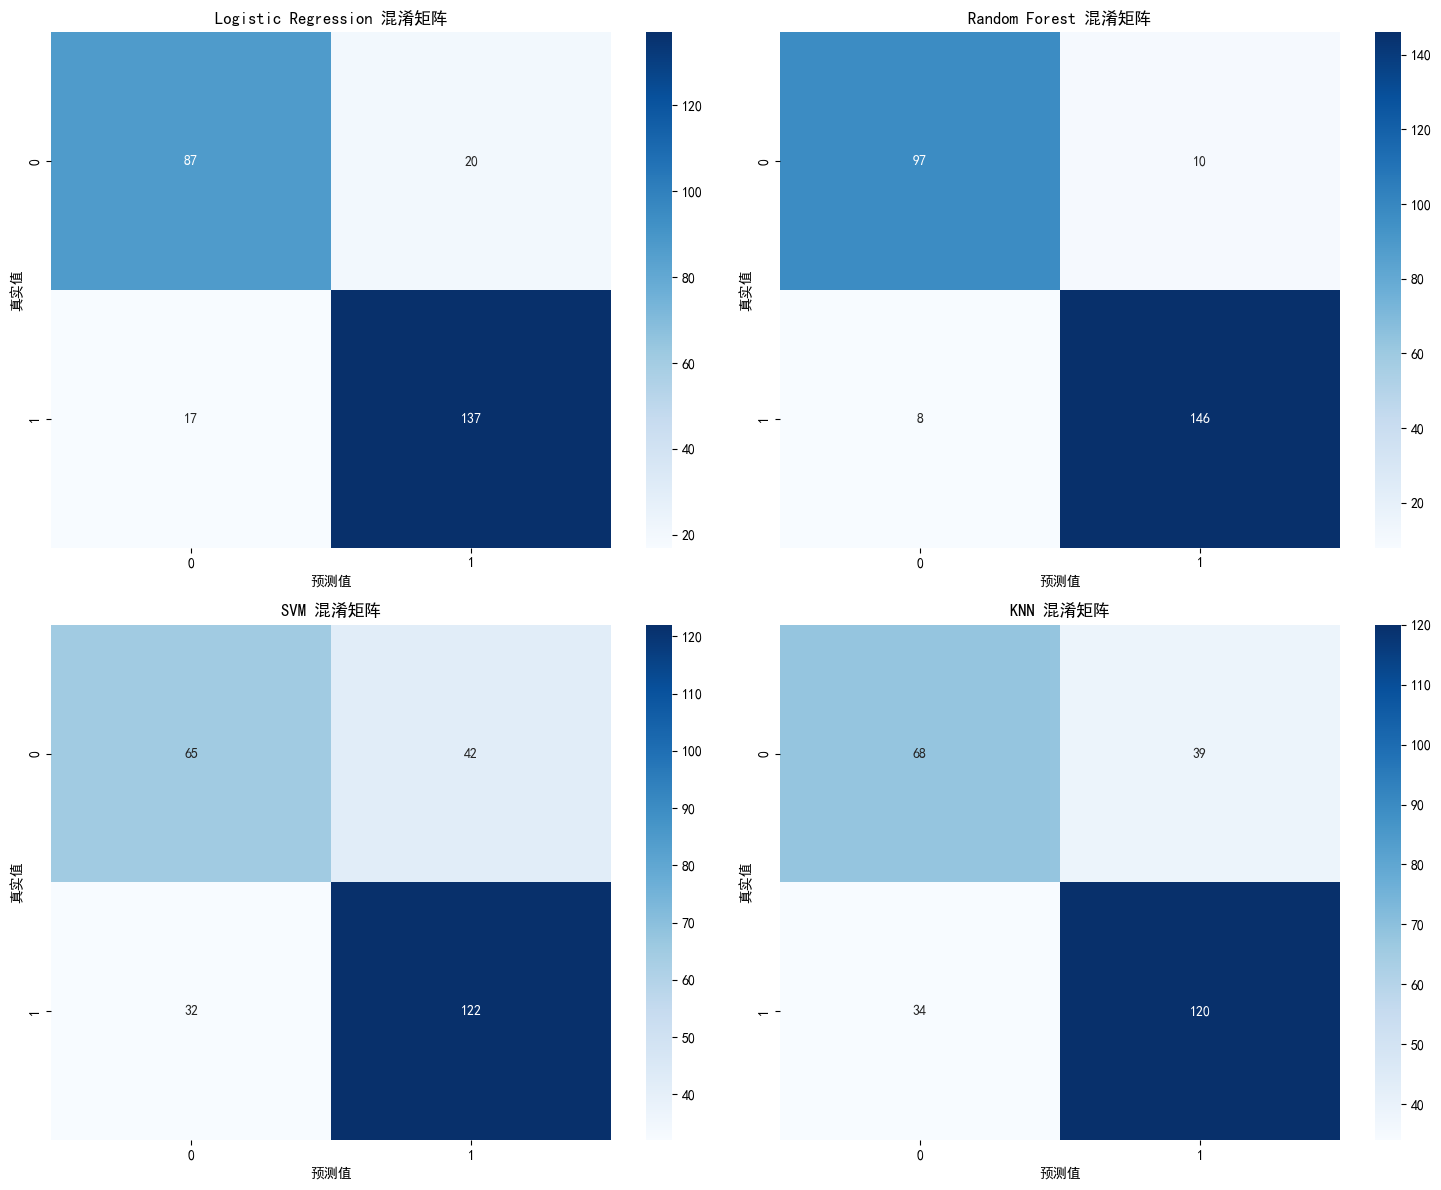


Logistic Regression 评估报告：
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       107
           1       0.87      0.89      0.88       154

    accuracy                           0.86       261
   macro avg       0.85      0.85      0.85       261
weighted avg       0.86      0.86      0.86       261


Random Forest 评估报告：
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       107
           1       0.94      0.95      0.94       154

    accuracy                           0.93       261
   macro avg       0.93      0.93      0.93       261
weighted avg       0.93      0.93      0.93       261


SVM 评估报告：
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       107
           1       0.74      0.79      0.77       154

    accuracy                           0.72       261
   macro avg       0.71      0.70      0.70       261
weighted avg   

In [29]:
# 使用之前调参后的模型
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'SVM': svm_model,
    'KNN': knn_model 
}

# 创建混淆矩阵可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    # 获取预测结果
    y_pred = model.predict(X_test)
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    
    # 绘制混淆矩阵热力图
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name} 混淆矩阵')
    axes[idx].set_xlabel('预测值')
    axes[idx].set_ylabel('真实值')

plt.tight_layout()
plt.show()

# 输出各模型的详细评估报告
for name, model in models.items():
    print(f"\n{name} 评估报告：")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

在这四种模型中，随机森林的表现最佳，它在精确率、召回率和F1分数这几个指标上都取得了较高的值。逻辑回归的表现次之，其各项指标较为均衡。支持向量机和KNN的表现相对较弱，它们的平均精确率、召回率和F1分数值相同且低于前两者。

#### 6.1.2 ROC曲线下的AUC

ROC：真阳性率 (TPR) 与假阳性率 (FPR) 的曲线

AUC：ROC曲线下的面积。AUC值越接近1，表示分类器性能越好

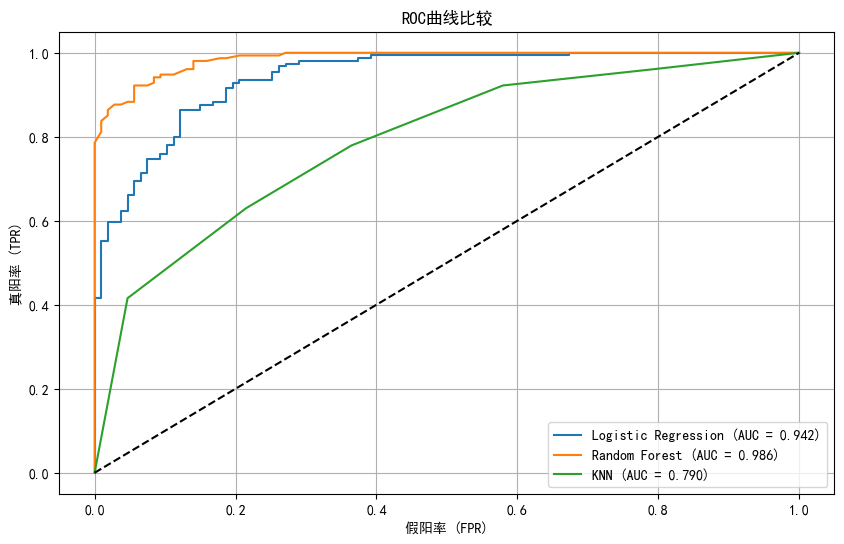


AUC值比较：
                        AUC
Logistic Regression  0.9420
Random Forest        0.9858
KNN                  0.7898


In [30]:
# 绘制ROC曲线
plt.figure(figsize=(10, 6))

# 存储每个模型的AUC值
auc_scores = {} 


for name, model in models.items():
    if hasattr(model, "predict_proba"):
        # 获取预测概率
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        # 计算FPR和TPR
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        # 计算AUC
        roc_auc = auc(fpr, tpr)
        auc_scores[name] = roc_auc
        # 绘制ROC曲线
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('假阳率 (FPR)')
plt.ylabel('真阳率 (TPR)')
plt.title('ROC曲线比较')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 打印F1分数和AUC值
print("\nAUC值比较：")
comparison_df = pd.DataFrame({
    'AUC': pd.Series(auc_scores)
})
print(comparison_df.round(4))

显然，依旧是随机森林保持领先，拉开了显著的差距。

### 6.2 最佳模型选择
基于模型参数调优后和前面的可视化评估结果，下面我们通过综合考虑准确率、F1分数和AUC值来选择最佳模型：

In [31]:
# 使用最佳参数创建模型
lr_model = LogisticRegression(C=0.1, max_iter=1000, solver='lbfgs', random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(C=100, gamma=0.001, random_state=42,probability=True)
knn_model = KNeighborsClassifier(algorithm='auto', n_neighbors=9, weights='distance')  

# 训练模型
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model, 
    'SVM': svm_model,
    'KNN': knn_model
}

# 计算评估指标
metrics = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 自定义评估指标计算
    custom_metric = 0.2 * accuracy + 0.25 * precision + 0.3 * recall + 0.25 * f1
    
    metrics[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'custom_metric': custom_metric  # 添加自定义评估指标，最佳模型评分的指标
    }

# 创建评估指标DataFrame
metrics_df = pd.DataFrame(metrics).T
print("\n各模型评估指标比较：")
print(metrics_df.round(4))


各模型评估指标比较：
                     accuracy  precision  recall      f1  custom_metric
Logistic Regression    0.8774     0.8910  0.9026  0.8968         0.8932
Random Forest          0.9310     0.9359  0.9481  0.9419         0.9401
SVM                    0.8506     0.8571  0.8961  0.8762         0.8723
KNN                    0.8544     0.8816  0.8701  0.8758         0.8713


各模型评估指标比较：

随机森林表现最佳（最佳模型评分分数最高），逻辑回归次之，支持向量机和KNN表现相对较弱。

因此选出了我们的最佳模型：随机森林

## 七、分析结论

### 7.1 项目总结

心脏病患者的数量和影响心脏病的因素逐渐增多，如何选择重要特征变量发现患有心脏病的患者是预测模型的核心内容。提前发现心脏病患者，及时介入治疗，有利于减低心脏病带来的死亡风险。精确率和召回率两个指标共同反应了模型是否正确预测患者患有心脏病的能力。

根据上图可得出四种机器学习模型中，基于随机森林模型相较于逻辑回归模型、支持向量机模型、KNN模型的分类性能更加优越。随着大数据时代的发展，大部分医学数据难以实现较为高效且快速的数据处理，故传统模型会面临淘汰。在较为前沿的机器学习算法所构建的模型中，随机森林在精确度、召回率、AUC (Area Under Curve)以及准确率四个方面都具有较好的效果。AUC的取值范围在0.5到1之间，越接近1表示模型的性能越好，说明随机森林模型在数据量较大、指标分类较为复杂的医学领域有较为广阔的前景。

同时，相较于逻辑回归模型、支持向量机模型、KNN模型，随机森林不依赖高维变量的组合优化。针对存在较大异质性的数据情况，我们可以加大决策树来消除具有极端情况的异质性，从而表现出良好的适用性和泛化性。

在大数据新发展格局下，数据类型多样，来源复杂，范围扩大，需要新型生物统计理论方法加以支撑。医疗统计在疾病预测、危险因素分析等方面起着至关重要的作用。随机森林模型的建立应不断与临床需求相适应，选出较为重要的影响因素纳入学习模型进行不断迭代，使得模型更加优化和完善。

灵活地将统计应用到医学事业中是时代的大势所趋，更是实现健康中国的重中之重。把人民健康放在首位，大幅提高健康水平，努力全方位、全周期保障人民健康，为全面建设社会主义现代化国家、全面推进中华民族伟大复兴打下坚实的健康基础。

### 7.2 项目局限性

**1. 数据集限制**
- 样本量相对有限：虽然本项目使用了Kaggle提供的数据集，但样本数量仅为1303条，可能不足以代表更广泛的人群特征，尤其是在不同地区和文化背景下的心脏病患者。
- 地域和人群代表性不足：数据集可能主要来源于特定地区或人群，导致模型在其他地区或人群中的适用性和准确性受到限制。
- 缺乏时序数据，无法追踪病情发展：本项目的数据集是静态的，缺乏对患者随时间变化的动态监测，无法分析心脏病的进展和治疗效果。

**2. 特征限制**
- 未包含生活方式等重要因素：如饮食习惯、运动量、吸烟和饮酒等生活方式因素，这些因素对心脏病的发生有显著影响，但未在数据集中体现。
- 部分医疗指标可能存在测量误差：如血压和胆固醇水平的测量可能受到多种因素的影响，导致数据的准确性和可靠性降低。
- 特征间的交互作用可能未被充分挖掘：虽然进行了基本的特征工程，但复杂的特征交互作用可能未被充分考虑，可能影响模型的预测能力。

**3. 模型限制**
- 预测结果缺乏细粒度的风险等级：模型输出的结果为二分类，未能提供更细致的风险评估，无法为临床决策提供更具体的指导。
- 对异常值和边界情况敏感：模型可能对数据中的异常值和边界情况表现出较高的敏感性，导致预测结果的不稳定性。
- 可解释性有待提高：虽然随机森林模型在性能上表现优越，但其复杂性使得模型的可解释性较差，临床医生可能难以理解模型的决策过程。

### 7.3 未来展望

**1. 增大数据集**
- 扩大数据采集范围和样本量：通过与医院和医疗机构合作，收集更多样本数据，尤其是来自不同地区和人群的数据，以提高模型的泛化能力。
- 引入更多类型的医疗指标：除了现有的特征外，增加生活方式、家族病史、基因信息等多维度数据，以全面评估心脏病风险。
- 建立长期追踪数据库：通过长期随访患者，建立动态数据库，分析心脏病的进展和治疗效果，为模型提供更丰富的数据支持。

**2. 模型优化**
- 尝试深度学习等更先进的算法：探索使用深度学习模型，如神经网络，来捕捉更复杂的特征关系，提高预测性能。
- 开发多级风险预测模型：构建多级模型，根据不同风险等级提供个性化的预防和治疗建议。
- 提升模型的可解释性：研究可解释性方法，如SHAP值和LIME，帮助临床医生理解模型的决策过程，提高模型的信任度。

**3. 应用拓展**
- 开发智能医疗辅助系统：将模型集成到医疗系统中，提供实时的风险评估和预警，辅助医生进行决策。
- 构建个性化预防方案：根据患者的具体情况，制定个性化的预防和治疗方案，提高干预效果。
- 推动预测模型的临床应用：通过临床试验验证模型的有效性，推动其在实际医疗中的应用。

**4. 研究方向**
- 探索更多风险因素的影响机制：深入研究生活方式、环境因素等对心脏病的影响机制，为模型提供更全面的理论支持。
- 研究不同人群的特异性表现：分析不同人群（如不同年龄、性别、种族）在心脏病风险上的差异，优化模型的适用性。
- 开发早期预警指标体系：基于模型的预测结果，建立早期预警指标体系，帮助医生及时识别高风险患者，进行早期干预。